In [6]:
from datetime import datetime, date

In [7]:
from IPython.html.widgets import interact, interactive, fixed

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [8]:
%reload_ext autoreload
%autoreload 2

In [10]:
cd ..

/Users/miguel/Jottacloud/devel/osqf2015


In [11]:
from model import *

In [12]:
from cytoolz import sliding_window, count, pipe, thread_first

In [13]:
import seaborn as sns
%matplotlib notebook

Load risk factors using Blaze

- Deutsche Bank US
- EURUSD

In [7]:
rf1 = RiskFactor.from_blaze("notebooks/db2.bcolz")
rfeurusd = CurrencyRiskFactor.from_blaze("notebooks/eurusd.bcolz")

perform the Filtered Historical Simulation

In [8]:
rf1.logreturns()
rf1.devol()
scenarios = rf1.fhs()

In [9]:
metric = VaR(99)

In [10]:
df = pd.DataFrame(scenarios, index=rf1.ts.index)


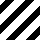
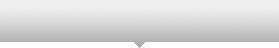
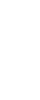
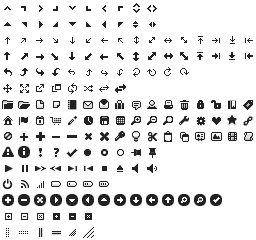
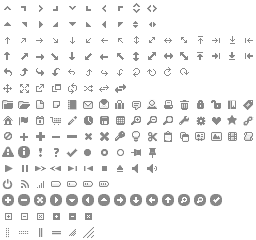
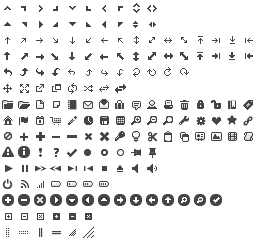
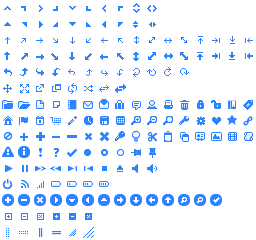
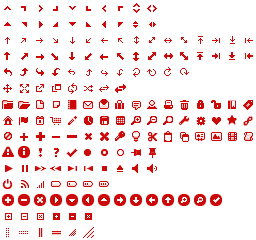
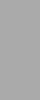
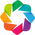
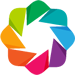
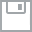
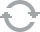
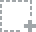
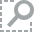
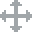
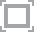
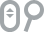

In [11]:
from bokeh.plotting import *
from bokeh.models import TapTool

output_notebook()

In [12]:
# TODO add this in interactive

In [42]:
def compute_scenarios():
    pass

def setup_results(df):
    results = pd.DataFrame({'neutral': df.icol(0),
                            'realized': df.shift(-1).icol(0)},
                            index=df.index )
    return results

def quantile_results(results, df, level):
    n_scenarios = len(df.columns) - 1
    results['q_upper'] = df.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=level)
    results['q_lower'] = df.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=100.-level)
    results.eval('shortfall = q_lower - realized')
    results.eval('shortfall_mid = shortfall * 0.5')
    return results

def mark_outliers(df):
    is_outlier = df.eval('(q_lower > realized)')
    df.loc[is_outlier,'bad'] = df[is_outlier]['realized']
    is_outlier = df.eval('q_upper < realized')
    df.loc[is_outlier,'good'] = df[is_outlier]['realized']
    return df

In [43]:
def process_full(df, level=99, start='2010-01-01'):
    df_restricted = df[df.index > start]
    return thread_first(df_restricted,
                        setup_results,
                        (quantile_results, df_restricted, level),
                        mark_outliers,
                        lambda x: x.ix[:-2])

In [44]:
def append_reverse(a, b):
    return np.append(a, np.flipud(b))

def make_envelope_ds(df, coordinates='relative'):
    """ construct data source """
    src = ColumnDataSource()
    d = df.index.tolist()
    src.add(append_reverse(d,d), 'date')
    return src

def update_envelope_ds(df, src, coordinates='relative'):
    """ update data source """
    factor = 0. if coordinates == 'absolute' else df.neutral
    y = append_reverse((df.q_lower - factor).values,
                       (df.q_upper - factor).values)
    src.add(y.tolist(), 'var')
    src.add((df.good - factor).values, 'good')
    src.add((df.bad - factor).values, 'bad')
    src.add((df.realized - factor).values, 'realized')
    return src


In [45]:
def make_envelope_plot(src):
    p = figure(title="Outliers", plot_height=400, plot_width=900, x_axis_type="datetime")
    p.patch('date', 'var', source=src, color='grey', fill_alpha=0.2)
    p.line('date', 'realized', source=src, line_width=1, color='steelblue')
    p.scatter(x='date', y='good', source=src, size=10, color='green', fill_alpha=0.2, )
    p.scatter(x='date', y='bad', source=src, size=10, color='red', fill_alpha=0.2, )
    return p

In [46]:
def create_outliers(src, original_p=None):
    x_column, h_column, y_column = 'date', 'shortfall', ''
#     w = 20*60*60*1000 # half day in ms

#     props = dict(title='x', plot_width=900, plot_height=300, x_axis_type='datetime', min_border=0)
#     if original_p is not None:
#         props['x_range'] = original_p.x_range
    
#     p = figure(**props)
#     p.rect(x=x_column, y=y_column, width=w, height=h_column, source=src)
# #     p.line(x=x_column, y=h_column, color='green', source=source)
# #     p.tools.append(TapTool(plot=p))
# #     p.tools.append(WheelZoomTool(dimensions=['width']))
#     return p

In [14]:
pd.stats.moments.rolling_count(df_res.bad, 250)

NameError: name 'df_res' is not defined

In [47]:
df_res = process_full(df)

In [48]:
ds_envelope = make_envelope_ds(df_res)
ds_envelope = update_envelope_ds(df_res, ds_envelope)

In [49]:
p = make_envelope_plot(ds_envelope)
show(p)

In [82]:
interact(update_confidence_level, confidence_level=(90, 99, 1));
interact(update_lambda, _lambda=(0.80, 0.99, 0.01));

In [81]:
def update_confidence_level(confidence_level=94, cfg=fixed(c)):
    cfg['confidence_level'] = confidence_level
    df_res = process_full(df, level=cfg['confidence_level'])
#     print( df_res.tail())
    ds = update_envelope_ds(df_res, cfg['src'])
    ds.push_notebook()

In [79]:
def update_lambda(_lambda=0.94, cfg=fixed(c)):
    rf1.devol(_lambda=cfg['l'])
    scenarios = rf1.fhs()
    df = pd.DataFrame(scenarios, index=rf1.ts.index)
    cfg['df'] = df
    df_res = process_full(df, level=cfg['confidence_level'])
    ds = update_envelope_ds(df_res, cfg['src'])
    ds.push_notebook()

In [77]:
# import collections
# Config = collections.namedtuple('Config', 'l confidence_level src df')
c = dict(confidence_level=99, l=0.94, src=ds_envelope, df=df)

In [69]:
c.confidence_level = 22

AttributeError: can't set attribute

In [17]:
results = pd.DataFrame(index=df.index[df.index > '2010-01-01'])
df_restricted = df[df.index > '2010-01-01']
n_scenarios = 250

results['neutral'] = df[df.index > '2010-01-01'].icol(0)
results['realized'] = df.shift(-1).icol(0)[df.index > '2010-01-01']

results['q_upper'] = df_restricted.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=99)
results['q_lower'] = df_restricted.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=1)

results['shortfall'] = results.eval('q_lower - realized')

def make_outliers_ds(df, start=None, end=None, coordinates='absolute'):
    """ construct data source """
    r = df
    ds = ColumnDataSource()
    ds.add(r.index[:-2], 'date')

    x = np.append(r.index, np.flipud(r.index))
    real = r.realized.values[:-2]
    if coordinates == 'absolute':
        y = np.append(r.q_lower, np.flipud(r.q_upper))
    else:
        y = np.append(r.q_lower - r.neutral, np.flipud(r.q_upper - r.neutral))
        real = real - r.neutral.values[:-2]
    
    ds.add(real, 'real')
    ds.add(x, 'x')
    ds.add(y, 'y')
    return ds

def make_shortfall_ds(df, start=None, end=None):
    ds = ColumnDataSource()
    shortfall_values = df.shortfall.values[:-2]
    ds.add(df.index[:-2], 'date')
    ds.add(np.clip(shortfall_values, 0., np.infty), 'shortfall')
    ds.add(np.clip(shortfall_values, 0., np.infty) * 0.5, 'shortfall_y')
    return ds

def make_outliers_plot(source=None):
    p = figure(title="simple line example", plot_height=400, plot_width=900, x_axis_type="datetime")
    p.patch('x', 'y', source=source, color='grey', fill_alpha=0.4)
    p.line('date', 'real', source=source, line_width=1, color='#444444')
    return p

In [18]:
def make_var_plot(source=None):
    p = figure(title="simple line example", plot_height=400, plot_width=900, x_axis_type="datetime")
    p.line('date', 'q_lower', source=source, line_width=1, color='#444444')
    return p

def create_outliers(source,original_p=None):
    x_column = 'date'
    h_column = 'shortfall'
    y_column = 'shortfall_y'
    w = 20*60*60*1000 # half day in ms
    props = dict(title='x', plot_width=900, plot_height=300, x_axis_type='datetime', min_border=0)
    if original_p is None:
        props['x_range'] = original_p.x_range
    p = figure(**props)
    p.rect(x=x_column, y=y_column, width=w, height=h_column, source=source)
#     p.line(x=x_column, y=h_column, color='green', source=source)
#     p.tools.append(TapTool(plot=p))
#     p.tools.append(WheelZoomTool(dimensions=['width']))
    return p


In [19]:
def update_shortfall_ds(df, src):
    shortfall_values = df.shortfall.values[:-2]
    src.data['shortfall'] = np.clip(shortfall_values, 0., np.infty)
    src.data['shortfall_y'] = np.clip(shortfall_values, 0., np.infty) * 0.5

In [20]:
def update_outliers_ds(df, src, coordinates='relative'):
    """ construct data source """
#     x = np.append(df.index, np.flipud(df.index))
    if coordinates == 'absolute':
        y = np.append(df.q_lower, np.flipud(df.q_upper))
    else:
        y = np.append(df.q_lower - df.neutral, np.flipud(df.q_upper - df.neutral))
    src.data['y'] = y
    return src

In [21]:
def make_quantiles_ds(df):
    """ construct data source """
    r = df
    ds = ColumnDataSource()
    ds.add(r.index[:-2], 'date')
    ds.add(r.q_lower[:-2], 'q_lower')
    ds.add(r.q_upper[:-2], 'q_upper')
    real = r.realized.values[:-2]    
    ds.add(real, 'real')
    return ds

ds_q = make_quantiles_ds(results)

In [22]:
p = make_var_plot(source=ds_q)
show(p)

In [23]:
conf_level = 0.99
def update_lambda(_lambda=0.94):
    rf1.devol(_lambda=1-_lambda)
    df = pd.DataFrame(rf1.fhs(), index=rf1.ts.index)
    df_restricted = df[df.index > '2010-01-01']
    results = pd.DataFrame(index=df_restricted.index)
    results['neutral'] = df_restricted.icol(0)
    results['realized'] = df.shift(-1).icol(0)[df.index > '2010-01-01']
    update_confidence_level(conf_level)
#     results = update_results
#     update_outliers_ds(results, ds)
#     update_shortfall_ds(results, ds2)
#     ds.push_notebook()
#     ds2.push_notebook()
#     results['q_upper'] = df_restricted.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=99)
#     results['q_lower'] = df_restricted.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=1)

# results['shortfall'] = results.eval('q_lower - realized')

def update_results(df, confidence_level):
    n_scenarios = 250
    df['q_upper'] = df_restricted.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=confidence_level*100)
    df['q_lower'] = df_restricted.icol(np.arange(1,n_scenarios+1)).apply(np.percentile, axis=1, q=(1-confidence_level)*100)
    df['shortfall'] = df.eval('q_lower - realized')
    return df

def update_confidence_level(confidence_level=0.99):
    conf_level = confidence_level
    update_results(results, confidence_level)
    ds_q.data['q_lower'] = results.q_lower[:-2]
    print(results.q_lower[:-2])
    ds_q.data['q_upper'] = results.q_upper[:-2]
    ds_q.push_notebook()
    update_outliers_ds(results, ds)
    update_shortfall_ds(results, ds2)
    ds.push_notebook()
    ds2.push_notebook()

In [25]:
# output_notebook()
ds = make_outliers_ds(results, coordinates='relative' )
# ds2 = make_shortfall_ds(results)
p = make_outliers_plot(source=ds)
# p2 = create_outliers(ds2, original_p=p)
# show(gridplot([[p],[p2]]))
show(p)

In [742]:
interact(update_lambda, _lambda=(0.80, 0.99, 0.01))
interact(update_confidence_level, confidence_level=(0.90, 0.99, 0.01))

Date
2010-01-04    70.866453
2010-01-05    72.249928
2010-01-06    71.027088
2010-01-07    71.885597
2010-01-08    74.450813
2010-01-11    74.096339
2010-01-12    71.777469
2010-01-13    71.516785
2010-01-14    71.190022
2010-01-15    67.506672
2010-01-19    68.500276
2010-01-20    66.511020
2010-01-21    63.416535
2010-01-22    59.871230
2010-01-25    61.444237
2010-01-26    59.444532
2010-01-27    60.262681
2010-01-28    59.292876
2010-01-29    58.856627
2010-02-01    61.109644
2010-02-02    62.948005
2010-02-03    61.722553
2010-02-04    57.111655
2010-02-05    57.046329
2010-02-08    55.516435
2010-02-09    59.244098
2010-02-10    59.817611
2010-02-11    58.997025
2010-02-12    57.885800
2010-02-16    60.890334
                ...    
2015-03-25    33.869117
2015-03-26    33.548243
2015-03-27    33.574775
2015-03-30    34.077729
2015-03-31    33.859127
2015-04-01    34.425206
2015-04-02    34.836832
2015-04-06    35.211279
2015-04-07    34.998439
2015-04-08    34.786401
2015-04-09 

### Testing Pandas Panel

In [119]:
pos = pd.Panel({'eurusd': rfeurusd.ts, 'db': rf1.ts})

In [120]:
pos['db',1:10,:]

,Value,LogReturns,Vola,DevolLogReturns
Date,,,,
1996-11-19,47.87,0.007759,NaN,NaN
1996-11-20,47.50,-0.007759,0.010973,-0.707107
1996-11-21,48.00,0.010471,0.009887,1.059066
1996-11-22,47.37,-0.013212,0.011737,-1.125696
1996-11-25,47.50,0.002741,0.010157,0.269817
1996-11-26,47.75,0.005249,0.009244,0.567887
1996-11-27,46.75,-0.021165,0.012218,-1.732230
1996-11-29,47.62,0.018439,0.013843,1.331959
1996-12-02,47.00,-0.013105,0.013674,-0.958375


In [162]:

indexer = (pos.major_axis > to_dt( '2010-01-01')) & (pos.major_axis < to_dt( '2015-01-01'))
pp = pos.take(indexer, axis='major')
# pos.take( indexer, axis='major')

In [178]:
pos.iloc[:, indexer,:]

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 1303 (major_axis) x 4 (minor_axis)
Items axis: db to eurusd
Major_axis axis: 2010-01-04 00:00:00 to 2014-12-31 00:00:00
Minor_axis axis: Value to DevolLogReturns